In [2]:
import csv
import matplotlib.pyplot as plt
import random

stat_dump_interval_ms = 100
stat_dump_interval_s = stat_dump_interval_ms / 1000

def plot_client_results(output_file, axs, xlim):
    # Define the file path
    input_file_path = 'logs/client_stats.log'

    client_data = {}
    start_time = None

    # Open and read the CSV file
    with open(input_file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row

        for row in reader:
            timestamp_str, client_id, op_type, count, max_val, min_val, avg, p50, p90, p99, p999 = row
            timestamp_s = int(timestamp_str) / 1000
            if start_time is None:
                start_time = timestamp_s

            if client_id not in client_data:
                client_data[client_id] = {'Tput': [], '50': [], '99': [], '999': [], 'ts': []}

            multiplier = 1
            if op_type == 'INSERT_BATCH':
                multiplier = 86
            elif op_type == 'SCAN':
                multiplier = 100

            client_data[client_id]['Tput'].append(multiplier * int(count) * 1024 / (1024 * 1024) / stat_dump_interval_s)
            client_data[client_id]['50'].append(float(p50) / 1000)
            client_data[client_id]['99'].append(float(p99) / 1000)
            client_data[client_id]['999'].append(float(p999) / 1000)
            client_data[client_id]['ts'].append(timestamp_s)

    def plot_metric(metric, title, ylabel, fig_loc, ylim):
        plt.figure(figsize=(8, 5))
        for client_id, stats in client_data.items():
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            data_points = [x for x in stats[metric]]
            axs[fig_loc[0]].plot(time_points, data_points, marker='o', label=f'Client {client_id}')
            with open(output_file, 'a') as outfile:
                outfile.write(f"client-{client_id}:metric-{metric}\n")
                outfile.write(f"time_points:{time_points}\n")
                outfile.write(f"data_points:{data_points}\n")

        if metric == 'Tput':
            # Get all the time points:
            all_time_points = [ts for client_id in client_data for ts in client_data[client_id]['ts']]
            all_time_points = sorted(list(set(all_time_points)))

            # For each time point, sum the client throughputs.
            client_tput_sums = []
            for ts in all_time_points:
                cur_sum = 0
                for client_id in client_data:
                    if ts in client_data[client_id]['ts']:
                        idx = client_data[client_id]['ts'].index(ts)
                        cur_sum += client_data[client_id]['Tput'][idx]
                client_tput_sums.append(cur_sum)
            all_time_points = [ts - start_time for ts in all_time_points]
            # axs[fig_loc[0]].plot(all_time_points, client_tput_sums, marker='o', label='Sum')

        axs[fig_loc[0]].set_title(title)
        axs[fig_loc[0]].set_xlabel('Time (s)')
        axs[fig_loc[0]].set_xlim(xlim)
        # axs[fig_loc[0]].set_ylim(0, 40)
        axs[fig_loc[0]].set_ylabel(ylabel)
        axs[fig_loc[0]].legend()
        axs[fig_loc[0]].grid(True)
        # axs[fig_loc[0]].set_ylim(-2, ylim)

    # Plotting each metric
    plot_metric('Tput', 'Client Throughput', 'MB/s', (0, 0), 550)
    plot_metric('50', 'Latency: 50p', '(ms)', (1, 0), 25)
    plot_metric('99', 'Latency: 99p', '99th Percentile (ms)', (2, 0), 2000)
    return start_time


In [3]:
import matplotlib.pyplot as plt
import re
from datetime import datetime

def plot_memtable_stats(output_file, axs, start_time, xlim, fig_loc):
    # Define the file paths
    input_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'

    cf_data = {}

    # Compile the regular expressions for matching lines
    
    # memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+)MB$')
    # memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+)MB$')
    memtable_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}).\d{6} \d+ .*.cc:\d+\] mt,([^,]+),([^,]+).*')


    def timestamp_to_seconds(timestamp_str):
        timestamp_str = timestamp_str.strip()
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            memtable_match = memtable_pattern.match(line)
            if not memtable_match:
                continue
                
            ts, cf_name, operation = memtable_match.group(1, 2, 3)
            operation = operation.strip()
            if cf_name not in cf_data:
                # Assume 0 active memtables to start. Thus, this is basically tracking imm tables pending flush
                cf_data[cf_name] = {"counts" : [0], "ts" : [start_time]}
            cf_data[cf_name]["ts"].append(timestamp_to_seconds(ts))
            if operation == 'add':
                cf_data[cf_name]["counts"].append(cf_data[cf_name]["counts"][-1] + 1)
            elif operation == 'remove':
                cf_data[cf_name]["counts"].append(cf_data[cf_name]["counts"][-1] - 1)
            else:
                print('invalid memtable operation name')
                
                
    def plot_metric(metric, ax, colors):
        idx = 0
        for cf_name, stats in cf_data.items():
            data_points = [int(x) for x in stats[metric]]
            time_points = [ts - start_time for ts in stats["ts"]]

            # Ignore initial memtable init.
            # ax.plot(time_points, data_points, marker='o', label=f'{cf_name}', color=colors[idx])
            if cf_name == 'default':
                label = 'Client 0'
            else:
                label = 'Client ' + cf_name[-1]
            ax.plot(time_points, data_points, marker='o', label=f'{label}')
            with open(output_file, 'a') as outfile:
                outfile.write(f"cf-{cf_name}:metric-{metric}\n")
                outfile.write(f"time_points:{time_points}\n")
                outfile.write(f"data_points:{data_points}\n")


            idx += 1
        ax.set_xlabel('Time (s)')
            
    # Plotting each metric
    plot_metric('counts', axs[fig_loc[0]], ['blue', 'lightblue'])
    # plot_metric('counts', axs[fig_loc[0]], ['orange', '#ffd580'])
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_title("Memtable Stats")
    axs[fig_loc[0]].legend(loc='upper left')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_ylabel('Count')

    # size_ax = axs[fig_loc[0]].twinx()
    # plot_metric('table_sizes', size_ax, ['blue', 'lightblue'])
    # size_ax.legend(loc='upper right')
    # size_ax.set_ylabel('Memtables Size (MB)')
    # size_ax.set_ylim(0,128)
    # plt.subplots_adjust(right=0.85)

def plot_level_stats(output_file, axs, fig_loc):
    # Define the file paths
    input_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'

    level_data = {}
    level_hit_pattern = re.compile(r'rocksdb.l(0|1|2|3).hit COUNT : (\d+).*')

    hits = [None, None, None, None]
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            level_hit_match = level_hit_pattern.match(line)
            if not level_hit_match:
                continue
            level, new_hits = level_hit_match.group(1, 2)
            # Always overwrite.
            hits[int(level)] = int(new_hits)

    cumulative_hits = []
    cumulative_count = 0
    for hit in hits:
        cumulative_count += hit
        cumulative_hits.append(cumulative_count)
    cumulative_hits_prop = [x / cumulative_count * 100 for x in cumulative_hits]
    
    axs[fig_loc[0]].plot(["l0", "l1", "l2", "l3"], cumulative_hits_prop, marker='o')

    axs[fig_loc[0]].set_title("Level Hits CDF")
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_ylabel('Cumulative Hits (%)')

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-level_hits\n")
        outfile.write(f"data_points:{cumulative_hits_prop}\n")


In [4]:
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime

def get_compaction_color(cf_name, level):
    # Red
    if cf_name == "default":
        if level == 1:
            return "#fc9598"
        elif level == 2:
            return "#ff696e"
        elif level == 3:
            return "#f02225"
        elif level == 4:
            return "#cf1d20"
        elif level == 5:
            return "#ab1619"
        elif level == 6:
            return "#851114"
        else:
        # elif level == 7:
            return "#610c0e"
    # Blue
    elif cf_name == "cf2":
        if level == 1:
            return "#95c2fc"
        elif level == 2:
            return "#699eff"
        elif level == 3:
            return "#225bf0"
        elif level == 4:
            return "#1d4bcf"
        elif level == 5:
            return "#1638ab"
        elif level == 6:
            return "#112985"
        else:
            # elif level == 7:
            return "#0c1d61"
    # Orange
    elif cf_name == "cf3":
        if level == 1:
            return "#ffd1b3"  # light orange
        elif level == 2:
            return "#ffa366"  # medium light orange
        elif level == 3:
            return "#ff7519"  # medium orange
        elif level == 4:
            return "#cc5c14"  # medium dark orange
        elif level == 5:
            return "#993d0f"  # dark orange
        elif level == 6:
            return "#66260a"  # darker orange
        else:
            # elif level == 7:
            return "#331305"  # darkest orange
    else:
        if level == 1:
            return "#c9fcb2"  # light green
        elif level == 2:
            return "#9ff987"  # medium light green
        elif level == 3:
            return "#75f35d"  # medium green
        elif level == 4:
            return "#58d740"  # medium dark green
        elif level == 5:
            return "#46b334"  # dark green
        elif level == 6:
            return "#328028"  # darker green
        else:
            # elif level == 7:
            return "#21571d"  # darkest green


def plot_rocksdb_events(output_file, axs, experiment_start_time, xlim, fig_loc):
    # log_file_path = '/mnt/multi-cf2/ycsb-rocksdb-data-2/LOG'
    # log_file_path = '/mnt/multi-cf/ycsb-rocksdb-data/LOG'
    log_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[(.*?)\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stalling writes because we have \d+ immutable memtables.*rate (\d+)')
    pending_compaction_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stalling writes because of estimated pending compaction bytes \d+ rate (\d+)')
    memtable_stop_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stopping writes because we have \d+ immutable memtables.*')

    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        timestamp_format = '%Y/%m/%d-%H:%M:%S.%f'
        dt = datetime.strptime(timestamp_str, timestamp_format)
        epoch = datetime(1970, 1, 1)
        micros_since_epoch = int((dt - epoch).total_seconds() * 1000000)
        return micros_since_epoch

    # Initialize lists for all events
    l0_stalls, memtable_stalls, pending_compaction_stalls = [], [], []
    compaction_data = {}
    flush_data = {}
    memtable_stops = []

    # Process the log file for stall, flush, and compaction events
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 and Memtable Stalls
            l0_match = l0_stall_pattern.search(line)
            if l0_match:
                timestamp_str, cf_name, rate = l0_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                l0_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_match = memtable_stall_pattern.search(line)
            if memtable_match:
                timestamp_str, cf_name, rate = memtable_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_stop_match = memtable_stop_pattern.search(line)
            if memtable_stop_match:
                timestamp_str, cf_name = memtable_stop_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stops.append((timestamp_micros, cf_name))

            pending_compact_match = pending_compaction_stall_pattern.search(line)
            if pending_compact_match:
                timestamp_str, cf_name, rate = pending_compact_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                pending_compaction_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            # Flush Events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, cf_name, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds) / 1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                if cf_name not in flush_data:
                    flush_data[cf_name] = []
                flush_data[cf_name].append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6))
            
            # Compaction Events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                try:
                    event_data = json.loads(json_str)
                    if event_data['event'] != 'compaction_finished':
                        continue
                    end_time_seconds = event_data['time_micros'] / 1e6
                    start_time_seconds = end_time_seconds - event_data['compaction_time_micros'] / 1e6
                    # start_time_seconds = event_data['time_micros'] / 1e6
                    # end_time_seconds = start_time_seconds + event_data['compaction_time_micros'] / 1e6
                    read_rate = event_data['read_rate']
                    write_rate = event_data['write_rate']
                    output_level = event_data['output_level']
                    cf_name = event_data['cf_name']
                    if cf_name not in compaction_data:
                        compaction_data[cf_name] = []
                    compaction_data[cf_name].append((start_time_seconds, end_time_seconds, read_rate, write_rate, output_level))
                except:
                    print("Compaction json error")

    # Determine the overall start time
    all_start_times = [d[0] for d in [flush_data[cf_name][0] for cf_name in flush_data] + [compaction_data[cf_name][0] for cf_name in compaction_data] + l0_stalls + memtable_stalls]
    # experiment_start_time = min(all_start_times)
    # internal_start_time = min(all_start_times)
    # print(internal_start_time)
    print(f'Exp start time: {experiment_start_time}')

    # Convert L0 and Memtable timestamps to seconds since experiment start
    l0_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in l0_stalls]
    l0_rates = [int(rate) for _, rate in l0_stalls]

    memtable_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in memtable_stalls]
    memtable_rates = [int(rate) for _, rate in memtable_stalls]

    pending_compaction_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in pending_compaction_stalls]
    pending_compaction_rates = [int(rate) for _, rate in pending_compaction_stalls]

    # Plotting
    # plt.figure(figsize=(8, 5))

    # Plot L0 and Memtable Stalls
    axs[fig_loc[0]].scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='blue', s=10)
    axs[fig_loc[0]].scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='purple', s=10)
    axs[fig_loc[0]].scatter(pending_compaction_timestamps, pending_compaction_rates, label='Pend Compact Stalls', color='orange', s=10)

    # TODO(tgriggs): Add stops to this
    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-L0_stalls\n")
        outfile.write(f"time_points:{l0_timestamps}\n")
        outfile.write(f"data_points:{l0_rates}\n")

        outfile.write(f"metric-memtable_stalls\n")
        outfile.write(f"time_points:{memtable_timestamps}\n")
        outfile.write(f"data_points:{memtable_rates}\n")

        outfile.write(f"metric-pending_compaction_stalls\n")
        outfile.write(f"time_points:{pending_compaction_timestamps}\n")
        outfile.write(f"data_points:{pending_compaction_rates}\n")
    
   
    # Plot Flush Events
    for cf_name in flush_data:
        if cf_name == "default":
            color = 'red'
            label = 'Client 0 Flush'
        elif cf_name == 'cf2':
            color = 'blue'
            label = 'Client 1 Flush'
        elif cf_name == 'cf3':
            color = 'orange'
            label = 'Client 2 Flush'
        else:
            color = 'green'
            label = 'Client 3 Flush'
        for start_time, rate, duration in flush_data[cf_name]:
            # Determine if this is the first occurrence of this cf_name for labeling
            # is_first = flush_data.index((start_time, rate, duration, cf_name)) == 0
            is_first = flush_data[cf_name].index((start_time, rate, duration)) == 0
            # is_first = compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0

            # Plotting with custom dashed line pattern for stripes
            axs[fig_loc[0]].hlines(rate, start_time - experiment_start_time, 
                                (start_time + duration) - experiment_start_time, 
                                colors=color, linewidth=4, 
                                linestyles=(0, (5, 10)) if is_first else 'solid', 
                                label=label if is_first else "")

    # Plot Compaction Events
    for cf_name in compaction_data:
        for start_time, end_time, read_rate, write_rate, output_level in compaction_data[cf_name]:
            # TODO(tgriggs): CHANGE 3 to ORANGE to match defaults
            color = get_compaction_color(cf_name, output_level)
            if cf_name == 'default':
                label = 'Client 0 Compaction'
            else:
                label = 'Client ' + cf_name[-1] + ' Compaction'
            axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label=label if compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
            # axs[fig_loc[0]].hlines(read_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label=label if compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
    
    # memtable_stop_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros in memtable_stops]
    memtable_stops_cf_seen = set()
    for i in range(len(memtable_stops)):
        memtable_stop_ts, cf_name = memtable_stops[i]
        memtable_stop_ts = (memtable_stop_ts / 1e6) - experiment_start_time
        if i == 0:
        # if cf_name not in memtable_stops_cf_seen:
            axs[fig_loc[0]].axvline(x=memtable_stop_ts, color='brown', linestyle='--', linewidth=0.5, label = 'Memtable Stops', alpha=0.5)
            memtable_stops_cf_seen.add(cf_name)
        else:
            axs[fig_loc[0]].axvline(x=memtable_stop_ts, color='brown', linestyle='--', linewidth=0.5, alpha=0.5)

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-flush\n")
        all_cfs = []
        all_rates = []
        all_start_points = []
        all_end_points = []
        for cf in flush_data:
            for start_time, rate, duration in flush_data[cf]:
                all_cfs.append(cf)
                all_rates.append(rate)
                all_start_points.append(start_time)
                all_end_points.append(start_time + duration)
        outfile.write(f"cf_names:{all_cfs}\n")
        outfile.write(f"reates:{all_rates}\n")
        outfile.write(f"start_points:{[start_time - experiment_start_time for start_time in all_start_points]}\n")
        outfile.write(f"end_points:{[end_time - experiment_start_time for end_time in all_end_points]}\n")

        outfile.write(f"metric-compaction\n")
        all_cfs = []
        all_read_rates = []
        all_write_rates = []
        all_start_points = []
        all_end_points = []
        for cf in compaction_data:
            for start_time, end_time, read_rate, write_rate, _ in compaction_data[cf]:
                all_read_rates.append(read_rate)
                all_write_rates.append(write_rate)
                all_start_points.append(start_time)
                all_end_points.append(end_time)
                all_cfs.append(cf)
        outfile.write(f"cf_names:{all_cfs}\n")
        outfile.write(f"read_rates:{all_read_rates}\n")
        outfile.write(f"write_rates:{all_write_rates}\n")
        outfile.write(f"start_points:{[start_time - experiment_start_time for start_time in all_start_points]}\n")
        outfile.write(f"end_points:{[end_time - experiment_start_time for end_time in all_end_points]}\n")
        
        outfile.write(f"metric-memtable_stops\n")
        outfile.write(f"time_points:{memtable_stops}\n")
        

    axs[fig_loc[0]].set_title('Database Operations Over Time')
    axs[fig_loc[0]].set_xlabel('Time (seconds since start of experiment)')
    axs[fig_loc[0]].set_ylabel('MB/s')
    axs[fig_loc[0]].set_xlim(xlim)
    # axs[fig_loc[0]].set_ylim(0, 450)
    axs[fig_loc[0]].legend()
    axs[fig_loc[0]].grid(True)

In [5]:
# Overall throughputs (client + system)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time

max_read_tput = 700
max_read_iops = 180000
max_write_tput = 400
max_write_iops = 100000

def timestamp_to_seconds(timestamp_str):
  timestamp = datetime.strptime(timestamp_str.rstrip(), '%Y-%m-%d %H:%M:%S.%f')
  epoch = datetime(1970, 1, 1)
  return (timestamp - epoch).total_seconds()

def plot_overall_tputs(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")

  # print(f"Timestamp: {timestamp_to_seconds(df_from_csv['Timestamp'][0])}")

  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  # Plotting
  # axs[fig_loc[0]].figure(figsize=(10, 6))
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rMB/s"], label='Read MB/s', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wMB/s"], label='Write MB/s', marker='o', color='tab:red')

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rMB_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["rMB/s"].tolist()}\n")

    outfile.write(f"metric-wMB_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["wMB/s"].tolist()}\n")

  axs[fig_loc[0]].set_title('SSD Throughput Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('MB/s')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0, 520)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  # # Creating a second y-axis
  # ax2 = axs[fig_loc[0]].twinx()
  # # Plotting on the secondary y-axis
  # ax2.plot(time_seconds, df_from_csv["rMB/s"]/max_read_tput, label='Read Util', marker='x', linestyle='--', color='tab:green')
  # ax2.plot(time_seconds, df_from_csv["wMB/s"]/max_write_tput, label='Write Util', marker='+', linestyle='--', color='tab:red')
  # ax2.set_ylabel('Utilization (based on tput)')
  # ax2.legend(loc='upper right')
  # ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rMB_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["rMB/s"]/max_read_tput).tolist()}\n")

    outfile.write(f"metric-wMB_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["wMB/s"]/max_write_tput).tolist()}\n")

def plot_overall_iops(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r/s"], label='Read IOPS', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["w/s"], label='Write IOPS ', marker='o', color='tab:red')

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rIOP_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["r/s"].tolist()}\n")

    outfile.write(f"metric-wIOP_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["w/s"].tolist()}\n")

  axs[fig_loc[0]].set_title('SSD IOPS Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('IOPS')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,16)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  # Creating a second y-axis
  ax2 = axs[fig_loc[0]].twinx()
  # Plotting on the secondary y-axis
  ax2.plot(time_seconds, df_from_csv["r/s"]/max_read_iops, label='Read IOPS Util', marker='x', linestyle='--', color='tab:green')
  ax2.plot(time_seconds, df_from_csv["w/s"]/max_write_iops, label='Write IOPS Util', marker='+', linestyle='--', color='tab:red')
  ax2.set_ylabel('Utilization (based on iops)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rIOP_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["r/s"]/max_read_iops).tolist()}\n")

    outfile.write(f"metric-wIOP_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["w/s"]/max_write_iops).tolist()}\n")

def plot_io_waittimes(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r_await"], label='Read Await (per req)', marker='o', color='tab:green')
  # axs[fig_loc[0]].plot(time_seconds, df_from_csv["w_await"], label='Write Await (per req)', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('IO Wait Times (queueing + servicing)')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Wait Time (ms)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  ax2 = axs[fig_loc[0]].twinx()
  ax2.plot(time_seconds, [df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))], label='Read Await (per KB)', marker='x', color='tab:green')
  # ax2.plot(time_seconds, [df_from_csv["w_await"][i] / df_from_csv["wareq-sz"][i] if df_from_csv["wareq-sz"][i] > 0 else df_from_csv["w_await"][i]   for i in range(len(df_from_csv["w_await"]))], label='Write Await (per KB)', marker='x', color='tab:red')

  ax2.set_ylabel('IO Wait Times per KB')
  ax2.legend(loc='upper right')
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-r_await\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["r_await"].tolist()}\n")

    outfile.write(f"metric-r_await_per_kb\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{[df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))]}\n")

def plot_io_reqsize(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rareq-sz"], label='Avg Read Size', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wareq-sz"], label='Avg Write Size', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('Avg IO Sizes')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Size (KB)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-r_size\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["rareq-sz"].tolist()}\n")

    outfile.write(f"metric-w_size\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["wareq-sz"].tolist()}\n")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_cpu_util(output_file, axs, start_time_shift, xlim, fig_loc):
    df = pd.read_csv("mpstat_results.csv")
    
    # Assuming core values are strings and stripping any potential whitespace
    df['core'] = df['core'].map(lambda x: x.strip())
    df_filtered = df[df['core'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])].copy()

    # Convert metrics to float
    df_filtered['usr'] = df_filtered['usr'].map(lambda x: float(x))
    df_filtered['sys'] = df_filtered['sys'].map(lambda x: float(x))
    df_filtered['iowait'] = df_filtered['iowait'].map(lambda x: float(x))
    df_filtered['soft'] = df_filtered['soft'].map(lambda x: float(x))
    df_filtered['idle'] = df_filtered['idle'].map(lambda x: float(x))

    # Calculate the sum of iowait and idle for each row
    df_filtered['sum_iowait_idle'] = df_filtered['iowait'] + df_filtered['idle']
    
    # For plotting purposes, assuming each row represents a sequential time unit
    time_seconds = np.arange(len(df_filtered))
    time_seconds = [x + start_time_shift for x in time_seconds]

    # Group by core and plot each group
    for core, group in df_filtered.groupby('core'):
        # Calculate the index for each group based on its length
        group_index = list(np.arange(len(group)))
        axs[fig_loc[0]].plot(group_index, [100 - x for x in group['sum_iowait_idle']], label=f'Core {core} idle+iowait')
        with open(output_file, 'a') as outfile:
            outfile.write(f"metric-cpu_util:core-{core}\n")
            outfile.write(f"time_points:{group_index}\n")
            outfile.write(f"data_points:{[100 - x for x in group['sum_iowait_idle']]}\n")

    axs[fig_loc[0]].set_title('CPU Utilization (all but iowait and idle)')
    axs[fig_loc[0]].set_xlabel('Time (seconds)')
    axs[fig_loc[0]].legend(loc='upper right')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(-2, 102)


In [7]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_rsched_stats(output_file, axs, start_time_s, xlim, fig_loc):
    start_time_us = start_time_s * 1e6
    # Initialize lists to store the data for each client
    timestamps = defaultdict(list)  # Dictionary to store timestamps for each client
    memtables_data = defaultdict(lambda: ([], []))  # (list of values before '-', list of values after '-')
    writes_data = defaultdict(list)
    reads_data = defaultdict(list)

    # Function to parse a line and extract the data
    def parse_csv_row(row):
        timestamp, client_id, write_rate_limit_kbs, read_rate_limit_kbs, write_buffer_size_kb, max_write_buffer_number = row
        timestamp = (float(timestamp) - start_time_us) / 1e6
        client_id = int(client_id)
        timestamps[client_id].append(timestamp)
        memtables_data[client_id][0].append(int(max_write_buffer_number))
        memtables_data[client_id][1].append(int(write_buffer_size_kb) / 1024)
        writes_data[client_id].append(int(write_rate_limit_kbs) / 1024)
        reads_data[client_id].append(int(read_rate_limit_kbs) / 1024)

    # Read the CSV file
    csv_file = 'logs/resource_shares.log'  # Replace with your CSV file name
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            parse_csv_row(row)

    # Helper function to calculate total allocations
    def calculate_total(data):
        max_length = max(len(lst) for lst in data.values())
        total_allocation = [0] * max_length
        for lst in data.values():
            for i in range(len(lst)):
                total_allocation[i] += lst[i]
        return total_allocation

    # Calculate total allocations
    if len(writes_data) == 0 and len(reads_data) == 0 and len(memtables_data) == 0:
        return

    # Plot the memtables data with two different axes
    ax1 = axs[fig_loc[0]]
    min_length = min(len(data[0]) for data in memtables_data.values())
    cumulative_data = np.zeros(min_length)

    for client in sorted(memtables_data.keys()):
        time_axis = timestamps[client][:min_length]
        current_data = np.array(memtables_data[client][0][:min_length])
        new_cumulative_data = cumulative_data + current_data
        
        ax1.plot(time_axis, new_cumulative_data, label=f'Client {client} #table')
        ax1.fill_between(time_axis, cumulative_data, new_cumulative_data, alpha=0.3)
        
        cumulative_data = new_cumulative_data

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Max num memtables')
    ax1.set_title('Memtable Limits')
    ax1.legend(loc='upper left')
    ax1.set_xlim(xlim)

    # Plot the writes data for all clients
    ax2 = axs[fig_loc[1]]
    min_length = min(len(writes_data[client]) for client in writes_data)
    cumulative_data = np.zeros(min_length)

    for client in sorted(writes_data.keys()):
        time_axis = timestamps[client][:min_length]
        current_data = np.array(writes_data[client][:min_length])
        new_cumulative_data = cumulative_data + current_data
        
        ax2.plot(time_axis, new_cumulative_data, label=f'Client {client}')
        ax2.fill_between(time_axis, cumulative_data, new_cumulative_data, alpha=0.3)
        
        cumulative_data = new_cumulative_data

    ax2.set_title('IO Write Rate Limit')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('MB/s')
    ax2.legend()
    ax2.set_xlim(xlim)
    # ax2.set_ylim(5, 300)

    # Plot the reads data for all clients
    ax3 = axs[fig_loc[2]]
    min_length = min(len(reads_data[client]) for client in reads_data)
    cumulative_data = np.zeros(min_length)

    for client in sorted(reads_data.keys()):
        time_axis = timestamps[client][:min_length]
        current_data = np.array(reads_data[client][:min_length])
        new_cumulative_data = cumulative_data + current_data
        
        ax3.plot(time_axis, new_cumulative_data, label=f'Client {client}')
        ax3.fill_between(time_axis, cumulative_data, new_cumulative_data, alpha=0.3)
        
        cumulative_data = new_cumulative_data

    ax3.set_title('IO Read Rate Limit')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('MB/s')
    ax3.legend()
    ax3.set_xlim(xlim)

    plt.tight_layout()
    # plt.savefig(output_file)
    plt.show()


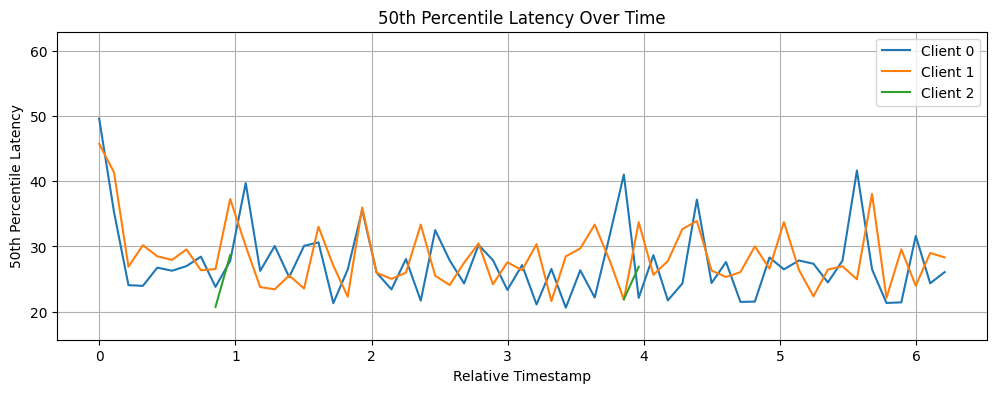

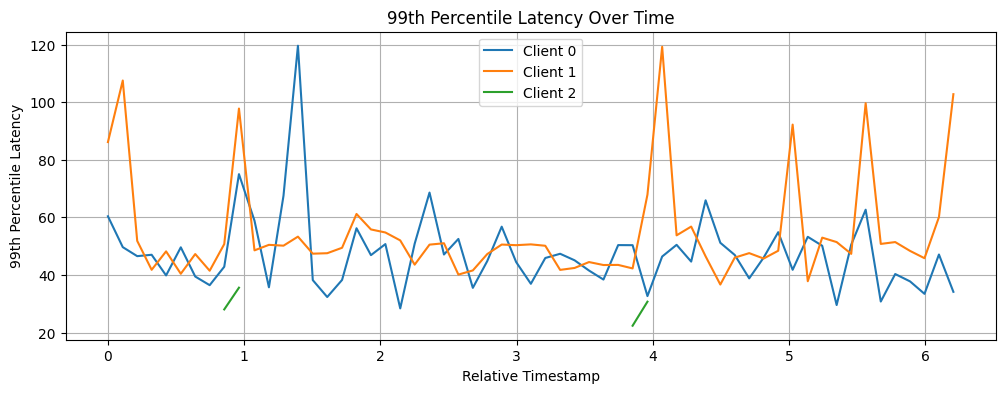

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'logs/client_stats.log'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Filter for op_type "QUEUE"
queue_data = data[data['op_type'] == 'QUEUE'].copy()

# Exclude client IDs '3' and '4'
# queue_data = queue_data[~queue_data['client_id'].isin([3, 4])]

# Adjust timestamps relative to the starting timestamp
queue_data['timestamp'] = (queue_data['timestamp'] - queue_data['timestamp'].min()) / 1000

# Create separate DataFrames for 50p and 99p latency
latency_50p = queue_data.pivot(index='timestamp', columns='client_id', values='50p')
latency_99p = queue_data.pivot(index='timestamp', columns='client_id', values='99p')

# Plot 50p latency
plt.figure(figsize=(12, 4))
for client_id in latency_50p.columns:
    plt.plot(latency_50p.index, latency_50p[client_id], label=f'Client {client_id}')
plt.title('50th Percentile Latency Over Time')
plt.xlabel('Relative Timestamp')
plt.ylabel('50th Percentile Latency')
plt.legend()
plt.grid(True)
plt.show()

# Plot 99p latency
plt.figure(figsize=(12, 4))
for client_id in latency_99p.columns:
    plt.plot(latency_99p.index, latency_99p[client_id], label=f'Client {client_id}')
plt.title('99th Percentile Latency Over Time')
plt.xlabel('Relative Timestamp')
plt.ylabel('99th Percentile Latency')
plt.legend()
# plt.xlim(280, 340)
# plt.ylim(0, 4000)
plt.grid(True)
plt.show()


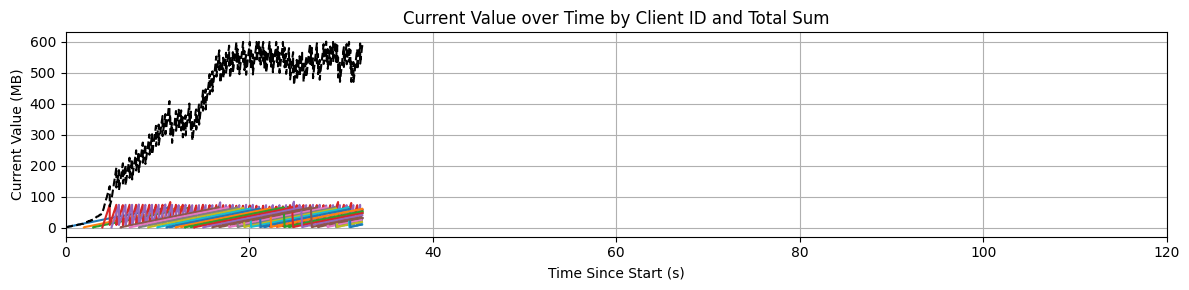

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

def plot_wbm_data(file_path):
    # Initialize a dictionary to store data for each client id
    data = defaultdict(list)

    # Read the file and parse relevant lines
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("wbm"):
                parts = line.strip().split(',')
                if len(parts) == 6:
                    try:
                        _, timestamp, client_id, operation, operation_size, current_value = parts
                        timestamp = int(timestamp) / 1000  # Convert to seconds
                        client_id = int(client_id)
                        current_value = int(current_value) / 1024 / 1024  # Convert to MB
                        data[client_id].append((timestamp, current_value))
                    except ValueError:
                        # Ignore lines that cause a ValueError and continue processing
                        continue

    # Determine the start time of the experiment
    start_time = min(min(values, key=lambda x: x[0])[0] for values in data.values())

    # Convert the data to numpy arrays for efficiency
    client_data = {}
    for client_id, values in data.items():
        adjusted_values = [(timestamp - start_time, current_value) for timestamp, current_value in values]
        client_data[client_id] = np.array(adjusted_values)

    # Generate the summed line efficiently
    all_timestamps = sorted(set(ts for values in client_data.values() for ts in values[:, 0]))
    client_latest_values = {client_id: 0 for client_id in client_data}  # Initialize latest values
    sum_values = []

    for ts in all_timestamps:
        current_sum = 0
        for client_id, values in client_data.items():
            # Update the latest value for the client if there is a new timestamp
            mask = values[:, 0] <= ts
            if np.any(mask):
                client_latest_values[client_id] = values[mask, 1][-1]  # Most recent value
            current_sum += client_latest_values[client_id]
        sum_values.append(current_sum)

    # Convert to DataFrame for plotting
    combined_df = pd.DataFrame({"timestamp": all_timestamps, "sum_value": sum_values})

    # Plot the data
    plt.figure(figsize=(12, 3))
    for client_id, values in client_data.items():
        plt.plot(values[:, 0], values[:, 1], label=f"Client {client_id}")
    
    # Add the summed line to the plot
    plt.plot(combined_df["timestamp"], combined_df["sum_value"], label="Sum of All Clients", linestyle="--", color="black")

    # Add labels, legend, and title
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Current Value (MB)")
    plt.title("Current Value over Time by Client ID and Total Sum")
    # plt.legend()
    plt.xlim(0, 120)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the path to your file
file_path = "logs/memtable_stats.txt"  # Replace with your file's path
plot_wbm_data(file_path)


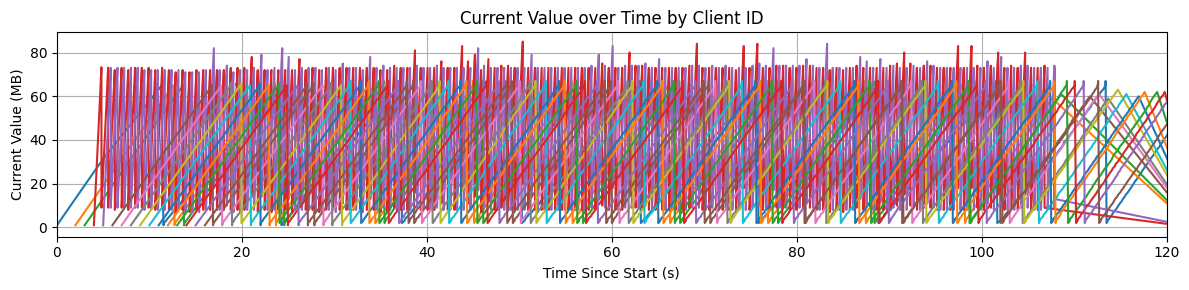

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

def plot_wbm_data(file_path):
    # Initialize a dictionary to store data for each client id
    data = defaultdict(list)

    # Read the file and parse relevant lines
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("wbm"):
                parts = line.strip().split(',')
                if len(parts) == 6:
                    try:
                        _, timestamp, client_id, operation, operation_size, current_value = parts
                        timestamp = int(timestamp) / 1000  # Convert to seconds
                        client_id = int(client_id)
                        # if (client_id not in [3, 4]):
                        #     continue
                        current_value = int(current_value) / 1024 / 1024  # Convert to MB
                        data[client_id].append((timestamp, current_value))
                    except ValueError:
                        # Ignore lines that cause a ValueError and continue processing
                        continue


    # Determine the start time of the experiment
    start_time = min(min(values, key=lambda x: x[0])[0] for values in data.values())

    # Convert the data to DataFrames for plotting
    client_dataframes = {}
    for client_id, values in data.items():
        adjusted_values = [(timestamp - start_time, current_value) for timestamp, current_value in values]
        df = pd.DataFrame(adjusted_values, columns=["timestamp", "current_value"])
        df.sort_values(by="timestamp", inplace=True)  # Ensure data is sorted by time
        client_dataframes[client_id] = df

    # Plot the data
    plt.figure(figsize=(12, 3))
    for client_id, df in client_dataframes.items():
        plt.plot(df["timestamp"], df["current_value"], label=f"Client {client_id}")

    # Add labels, legend, and title
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Current Value (MB)")
    plt.title("Current Value over Time by Client ID")
    # plt.legend()
    plt.grid(True)
    # plt.ylim(0, 256)  
    plt.xlim(0, 120)  
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the path to your file
file_path = "logs/memtable_stats.txt"  # Replace with your file's path
plot_wbm_data(file_path)

In [ ]:
import time 

def generate_plots(xlim, output_file):
  _, axs = plt.subplots(13, 1, figsize=(8, 50))
  plt.subplots_adjust(hspace=0.4)
  start_time_s = plot_client_results(output_file, axs, xlim)
  plot_rocksdb_events(output_file, axs, start_time_s, xlim, (3,0))
  plot_memtable_stats(output_file, axs, start_time_s, xlim, (4,0))

  start_time_shift = 0
  plot_overall_tputs(output_file, axs, start_time_shift, xlim, (5,0))
  plot_overall_iops(output_file, axs, start_time_shift, xlim, (6,0))
  plot_io_waittimes(output_file, axs, start_time_shift, xlim, (7,0))
  plot_io_reqsize(output_file, axs, start_time_shift, xlim, (8,0))
  plot_cpu_util(output_file, axs, start_time_shift, xlim, (9,0))

  # plot_level_stats(output_file, axs, (10, 0))
  plot_rsched_stats(output_file, axs, start_time_s, xlim, (10, 11, 12))
  plt.show()

xlim = (0, 120)
output_file = "results/timeseries_" + str(int(time.time())) + ".txt"
generate_plots(xlim, output_file)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'logs/client_stats.log'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Filter for op_type "QUEUE"
queue_data = data[data['op_type'] == 'QUEUE']

# Create separate DataFrames for 50p and 99p latency
latency_50p = queue_data.pivot(index='timestamp', columns='client_id', values='50p')
latency_99p = queue_data.pivot(index='timestamp', columns='client_id', values='99p')

# Plot 50p latency
plt.figure(figsize=(12, 3))
for client_id in latency_50p.columns:
    plt.plot(latency_50p.index, latency_50p[client_id], label=f'Client {client_id}')
plt.title('50th Percentile Latency Over Time')
plt.xlabel('Timestamp')
plt.ylabel('50th Percentile Latency')
plt.legend()
plt.grid(True)
plt.show()

# Plot 99p latency
plt.figure(figsize=(12, 3))
for client_id in latency_99p.columns:
    plt.plot(latency_99p.index, latency_99p[client_id], label=f'Client {client_id}')
plt.title('99th Percentile Latency Over Time')
plt.xlabel('Timestamp')
plt.ylabel('99th Percentile Latency')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# # 50p Latency
# values = np.array([
#     [4.92, 5.13, 4.99],
#     [5.16, 4.98, 5.04],
#     [0.1, 0.1, 0.1],
#     [15.67, 10.12, 10.31] 
# ])


# # 99p Latency
# values = np.array([
#     [250, 1200, 10],
#     [800, 4000, 10],
#     [1, 1, 1],
#     # [0, 3000, 0],
#     [100, 15, 16] 
# ])

# # Avg Tput
# values = np.array([
#     [8.4*x for x in [4.061, 4.065, 4.058]],
#     [8.4*x for x in [6.562, 6.556, 6.559]],
#     [8.4*x for x in [13.62, 11.7, 15.57]],
#     [176, 100, 200]
# ])

# Utilization
values = np.array([
    [100, 61.9, 100],
    [100, 73, 100],
    [60, 60, 100],
])


# categories = ['Small Burst', 'Large Burst', 'Steady Writer', 'Reader']
categories = ['Read SSD IO', 'Write SSD IO', 'Peak Memtable']
metric_labels = ['No IO Mgmnt', 'Static Alloc', 'FairDB']

bar_width = 0.25
x_positions = np.arange(len(categories))

fig, ax = plt.subplots()

colors = ['tab:blue', 'tab:orange', 'tab:green']

# Plot bars and add labels
for i in range(values.shape[1]):
    bars = ax.bar(
        x_positions + i * bar_width, 
        values[:, i], 
        width=bar_width, 
        color=colors[i], 
        label=metric_labels[i]
    )

# Customizing the plot
ax.set_xlabel('Clients', fontsize=18)
ax.set_ylabel('Utilization %', fontsize=18)
ax.set_title('Average Resource Utilization', fontsize=18)
ax.set_xticks(x_positions + bar_width)
# plt.yscale('log')
plt.yticks(fontsize=18)
# plt.xticks(fontsize=12)
plt.xticks(rotation=15)

ax.set_xticklabels(categories)
ax.legend(fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# # 50p Latency
# values = np.array([
#     [4.92, 5.13, 4.99],
#     [5.16, 4.98, 5.04],
#     [0.1, 0.1, 0.1],
#     [64.67, 10.12, 10.31] 
# ])


# # 99p Latency
# values = np.array([
#     [250, 1200, 10],
#     [800, 4000, 10],
#     [1, 1, 1],
#     # [0, 3000, 0],
#     [100, 15, 16] 
# ])

# Avg Tput
values = np.array([
    [145, 120, 405],
    [171, 142, 640],
])

# # Utilization
# values = np.array([
#     [100, 100, 61.9],
#     [100, 73, 100],
#     [60, 60, 100],
# ])


categories = ['Small Burst', 'Large Burst']
# categories = ['Read SSD IO', 'Write SSD IO', 'Peak Memtable']
metric_labels = ['No IO Mgmnt', 'Static Alloc', 'FairDB']

bar_width = 0.25
x_positions = np.arange(len(categories))

fig, ax = plt.subplots()

colors = ['tab:blue', 'tab:orange', 'tab:green']

# Plot bars and add labels
for i in range(values.shape[1]):
    bars = ax.bar(
        x_positions + i * bar_width, 
        values[:, i], 
        width=bar_width, 
        color=colors[i], 
        label=metric_labels[i]
    )

# Customizing the plot
ax.set_xlabel('Clients', fontsize=18)
ax.set_ylabel('MB/s', fontsize=18)
ax.set_title('Average Throughput (during burst)', fontsize=18)
ax.set_xticks(x_positions + bar_width)
# plt.yscale('log')
plt.yticks(fontsize=18)
# plt.xticks(fontsize=12)
plt.xticks(rotation=15)

ax.set_xticklabels(categories)
ax.legend(fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


categories = ['No IO Mgmnt', 'Static Alloc', 'FairDB']
values = [122, 114, 123]
colors = ['tab:orange', 'tab:green', 'tab:red']
plt.bar(categories, values, color=colors)

# Add title and labels
plt.title('50p Latency', fontsize=22)
plt.ylabel('Average Throughput (MB/s)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Policy 1', 'Policy 2', 'Policy 3']
values1 = [10, 75, 75]
values2 = [14, 123, 122]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
colors = ['tab:orange', 'tab:green', 'tab:blue', 'hotpink']

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values1, width, label='Average Read Tput', color=colors)
bars2 = ax.bar(x + width/2+.05, values2, width, label='During read interval(s)', color=colors)

# Adding black stripes to the second set of bars
for bar in bars2:
    bar.set_hatch('//')

# Add some text for labels, title and custom x-axis tick labels, etc.

plt.title('Compaction Read IO Tput', fontsize=22)
plt.ylabel('Tput MB/s', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_yticks([0, 20, 40, 60, 80, 100, 120, 140])
ax.legend(fontsize=12)

fig.tight_layout()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt


categories = ['Policy 1', 'Policy 2', 'Policy 3']
values = [166, 130, 148]
colors = ['tab:orange', 'tab:green', 'tab:blue', 'hotpink']
plt.bar(categories, values, color=colors)

# Add title and labels
plt.title('Other Readers Avg Tput', fontsize=22)
plt.ylabel('Tput MB/s', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the log file
log_file = 'status_thread.txt'
data = []
start_time = None

with open(log_file, 'r') as file:
    for line in file:
        parts = line.strip().split(',')
        try:
          timestamp = (int(parts[1]) - 1721958769497754) / 1e3
          # if start_time == None:
          #   start_time = timestamp
          #   print(start_time)
          # timestamp -= 1721809680156737
          io_op_type = parts[2]
          io_request_size = int(parts[3]) / 1024
          resource_max_capacity = int(parts[4]) / 1024
          data.append((timestamp, io_op_type, io_request_size, resource_max_capacity))
        except IndexError:
          # Skip lines with invalid numeric values
          continue
        except ValueError:
          continue

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Timestamp', 'IOType', 'RequestSize', 'MaxCapacity'])

# Plot the data
plt.figure(figsize=(12, 6))

# Scatter plot for read and write operations
read_data = df[df['IOType'] == 'read']
write_data = df[df['IOType'] == 'write']

plt.scatter(read_data['Timestamp'], read_data['RequestSize'], color='red', label='Read')
plt.scatter(write_data['Timestamp'], write_data['RequestSize'], color='blue', label='Write')

# Plot the max capacity as a horizontal line
plt.axhline(y=df['MaxCapacity'].iloc[0], color='green', linestyle='--', label='Max Capacity')

# Adding titles and labels
plt.title('IO Usage Over Time')
plt.xlabel('Time (ms)')
plt.ylabel('IO Request Size (KB)')
plt.legend()

plt.xlim(60 * 1000, 60.5 * 1000)

# Show the plot
plt.show()


In [ ]:
# Assuming 'df' is already defined and contains the log data

# Compute inter-read times
read_timestamps = df[df['IOType'] == 'read']['Timestamp'].sort_values().diff().dropna()
read_percentiles = read_timestamps.quantile([0.5, 0.9, 0.95])

# Compute inter-write times
write_timestamps = df[df['IOType'] == 'write']['Timestamp'].sort_values().diff().dropna()
write_percentiles = write_timestamps.quantile([0.5, 0.9, 0.95])

# Display the results
print("Inter-read time percentiles (in ms):")
print(read_percentiles)

print("\nInter-write time percentiles (in ms):")
print(write_percentiles)
